In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [2]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = False
glob_det = 'det'

Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                               mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
samples = simulator.sample(Nsims=Nsims)  
obs = simulator.sample(1)

In [3]:
p_marker = 'p' if glob_pve_bounds == True else 'n'
b_marker = 'b' if glob_bkg == True else 'q'
d_marker = 'd' if glob_det == 'det' else 's'
# s_marker = '_asymL2'
# m_marker = '_m1' # m0 - plain, m1 - learns binwise mu, m2 - learns theta 
# netid = p_marker+b_marker+d_marker+str(train_bounds)+s_marker+m_marker
netid = p_marker+b_marker+d_marker+str(train_bounds)

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_46604/600084491.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


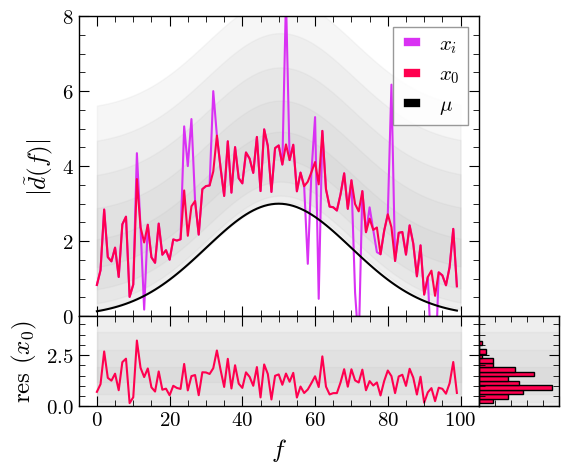

In [4]:
test = simulator.sample(1)
quantiles_long = np.array([7.1508466e-04, 7.9613253e-03, 5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00,
       4.5491748e+00, 5.4850187e+00], dtype=np.float32)

quantiles = np.array([5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00], dtype=np.float32)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.plot(test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
grid = torch.linspace(0, 100, 100)
for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

pf.fix_plot([ax1,ax2, ax3])
plt.tight_layout()

In [5]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

In [6]:
network_BCE = Network_BCE()
checkpoint = torch.load(f'../week5/networks/network_BCE_{netid}_complex', weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
network_BCE.load_state_dict(new_state_dict)
# network_BCE.cuda().double().eval()
network_BCE.to(dtype=torch.float32,device='mps').eval()

model_BCE = BCELossModule(network_BCE, learning_rate=3e-3)
checkpoint = torch.load(f'../week5/networks/model_BCE_{netid}_complex', weights_only=False,map_location=torch.device('cpu'))
sd = checkpoint.state_dict()
# new_state_dict = {}
for key in sd:
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = sd[key]
    
model_BCE.load_state_dict(sd)
# network_BCE.cuda().double().eval()
model_BCE.to(dtype=torch.float32,device='mps').eval()

BCELossModule(
  (model): Network_BCE(
    (net): UNet1d(
      (inc): DoubleConv1d(
        (double_conv): Sequential(
          (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (downs): ModuleList(
        (0): Down1d(
          (maxpool_conv): Sequential(
            (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (1): DoubleConv1d(
              (double_conv): Sequential(
                (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
                (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (

In [7]:
def dict_to_mps(x):
    if isinstance(x, dict):
        return {k: dict_to_mps(v) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(device='mps')
    elif isinstance(x, list):
        return [dict_to_mps(item) for item in x]
    else:
        return x

def dict_to_cpu(x: dict) -> dict:
    out = {}
    for key, val in x.items():
        if isinstance(val, torch.Tensor):
            out[key] = val.to(device='cpu')
        else:
            out[key] = val
    return out


def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_mps(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

In [9]:
# N_mc = 2e6

# batch_size = 2048*2
# N_batch = int(N_mc / batch_size)
# ts_bin_H0_BCE = []
# ts_bin_H1_BCE = []
# eps_real_BCE = []
# for _ in tqdm(range(N_batch)):
#     mc_samples = simulator.sample(batch_size)
#     ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
#     ts_bin_H1_BCE.append(ts_sbi(mc_samples, model=1))
#     eps_real_BCE.append(mc_samples['epsilon'])

# ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)
# ts_bin_H1_BCE = np.concatenate(ts_bin_H1_BCE)
# eps_real_BCE = np.concatenate(eps_real_BCE)

# np.save('../../data_bin/BCE_ref/ts_bin_H0_BCE', ts_bin_H0_BCE)
# np.save('../../data_bin/BCE_ref/ts_bin_H1_BCE', ts_bin_H1_BCE)

ts_bin_H0_BCE = np.load('../../data_bin/BCE_ref/ts_bin_H0_BCE.npy')
ts_bin_H1_BCE = np.load('../../data_bin/BCE_ref/ts_bin_H1_BCE.npy')


/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_46604/507189932.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


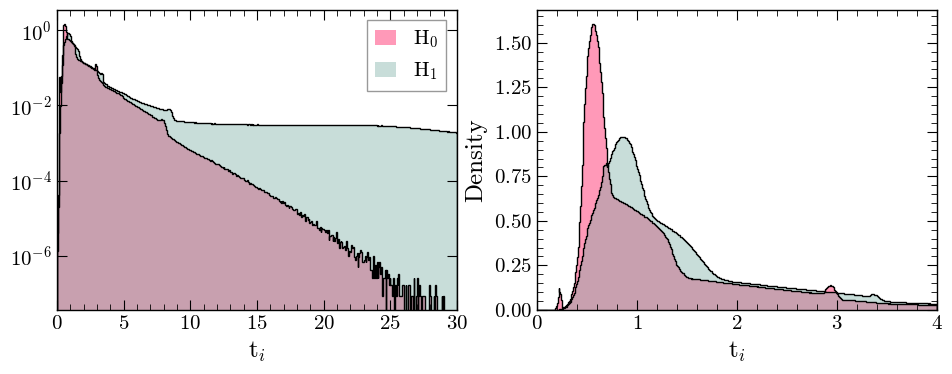

In [10]:
fig, ax1 = pf.create_plot()
ax2 = fig.add_axes((1.2,0,1,1))


dat = [ts_bin_H0_BCE,ts_bin_H1_BCE]
cz = ['#ff004f', '#77aca2']
labz = [r'H$_0$',r'H$_1$']

for i, d in enumerate(dat):

    b = d.flatten()

    minb = min(b)

    topz = [30,4]

    for j,ax in enumerate([ax1,ax2]):
        bbins = np.linspace(0,topz[j],500)
        ax.hist((b-minb), color=cz[i], density=True, bins = bbins, alpha=0.4, label=labz[i])
        ax.hist((b-minb), color='black', histtype='step', density=True, bins=bbins)
        ax.set_xlim(0,topz[j])

        

ax2.set_ylabel('Density')
ax2.set_xlabel(r't$_i$')
ax1.set_xlabel(r't$_i$')

ax1.legend()
ax1.set_yscale('log')

pf.fix_plot([ax1,ax2])

plt.tight_layout()
plt.savefig(f'figs/{netid}/BCE_H0_dist.png', dpi=700, bbox_inches = 'tight')

In [ ]:
fig, ax1 = pf.create_plot()
ax2 = fig.add_axes((1.2,0,1,1))

d = ts_bin_H0_BCE.flatten()
dat = d - min(d)
# print(f'{np.sum(dat<0)}')

bbinz = np.linspace(0,4,500)

ax1.hist(dat, color='#ff004f', density=True, bins = bbinz, alpha=0.4)
# ax1.hist(dat, color='black', histtype='step', density=True, bins=bbinz)

KDE = gaussian_kde(dat)
grid = np.linspace(0,4,500)
estimator = KDE.evaluate(grid)
# ax1.scatter(grid, estimator, s=20, marker='x', color='black', zorder=10)
ax1.plot(grid, estimator, lw=4, color='black')


bbinz2 = np.linspace(0,30,500)
estimator2 = KDE.evaluate(bbinz2)

ax2.hist(dat, color='#ff004f', density=True, bins = bbinz2, alpha=0.4)
ax2.plot(grid, estimator2, lw=4, color='black')
ax2.set_yscale('log')
ax2.set_ylim(1e-8,1.6)

pf.fix_plot([ax1,ax2])

In [ ]:
fig, ax1 = pf.create_plot()
ax2 = fig.add_axes((1.2,0,1,1))

d = ts_bin_H1_BCE.flatten()
dat = d - min(d)
# print(f'{np.sum(dat<0)}')

bbinz = np.linspace(0,4,500)

ax1.hist(dat, color='#ff004f', density=True, bins = bbinz, alpha=0.4)
# ax1.hist(dat, color='black', histtype='step', density=True, bins=bbinz)

KDE = gaussian_kde(dat)
grid = np.linspace(0,4,500)
estimator = KDE.evaluate(grid)
# ax1.scatter(grid, estimator, s=20, marker='x', color='black', zorder=10)
ax1.plot(grid, estimator, lw=4, color='black')


bbinz2 = np.linspace(0,30,500)
estimator2 = KDE.evaluate(bbinz2)

ax2.hist(dat, color='#ff004f', density=True, bins = bbinz2, alpha=0.4)
ax2.plot(grid, estimator2, lw=4, color='black')
ax2.set_yscale('log')
ax2.set_ylim(1e-8,1.6)

pf.fix_plot([ax1,ax2])